In [ ]:
# G. Hayes 2024
# This is script is used to load in the preprocessed ramp data and fit it with linear and non-linear (4- and 5-parameter) models using least squares regression and Bayesian modelling for the analysis presented in:
# G. Hayes, S. Sparks, J. Pinto, and D. P. Bulte, “Ramp protocol for non-linear cerebrovascular reactivity with transcranial doppler ultrasound,” Journal of Neuroscience Methods, vol. 416, p. 110381, Apr. 2025, doi: 10.1016/j.jneumeth.2025.110381.

# Updated this script for your purposes, notably:
# - the data folder name
# - the data file name
# - the output file name
# - alter parameters that may differ for your data

# It should be noted that channel 1 of the pwl data is the CO2, channel 2 is the O2 data, channel 3 is the raw TCD data, channel 4 is the PPG data, and channel 5 is the comment data.

In [73]:
import numpy as np
import pandas as pd
from pandas import *
import os,sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.signal import find_peaks
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats.distributions import t
import seaborn as sns
import ramp_cvr_functions as cvr_func
import copy
import csv
from scipy.signal import resample

save_fig = True
save_log = True

In [ ]:
local = 'path/to/data/'

# sub-001
mca_filepath = 'sub-001/ses-01/sub-001_ses-01_YYYYMMDD_task_dat-20230816_MCAvmean.csv'
petco2_filepath = 'sub-001/ses-01/sub-001_ses-01_YYYYMMDD_task_dat-20230816_petco2.csv'
peak_min_distance = 340
peak_prominence = 1
start_search = 240

# # sub-002
# mca_filepath = 'sub-002/ses-01/sub-002_ses-01_YYYYMMDD_task_dat-20230816_MCAvmean.csv'
# petco2_filepath = 'sub-002/ses-01/sub-002_ses-01_YYYYMMDD_task_dat-20230816_petco2.csv'
# peak_min_distance = 340
# peak_prominence = 1
# start_search = 240

In [75]:
out_dir = local

# pull the subject number from the file path
sub_num = mca_filepath.split('/')[0].split('-')[1]

In [ ]:
# Load in the MCAvmean and petco2 data by any filename ending in _MCAvmean.csv and _petco2.csv
mca = pd.read_csv(local + mca_filepath)
petco2 = pd.read_csv(local + petco2_filepath)

# # remove the duplicate index column
# mca = mca.drop(mca.columns[0], axis=1)
# petco2 = petco2.drop(petco2.columns[0], axis=1)

# print the shape of the data
print('mca data shape', mca.shape)
print('petco2 data shape', petco2.shape)

# print the headers of the data
print('mca data headers', mca.head())
print('petco2 data headers', petco2.head())

# print the number of nan values in the data
print('number of nan values in the mca data', mca.isnull().sum())
print('number of nan values in the petco2 data', petco2.isnull().sum())

(165250, 2)
(165250, 2)
   Unnamed: 0  MCAvmean (cm/s)
0           0              NaN
1           1              NaN
2           2              NaN
3           3              NaN
4           4              NaN
   Unnamed: 0  PETCO2 (mmHg)
0           0      32.679034
1           1      32.679034
2           2      32.679034
3           3      32.679034
4           4      32.679034
Unnamed: 0            0
MCAvmean (cm/s)    5797
dtype: int64
Unnamed: 0       0
PETCO2 (mmHg)    0
dtype: int64


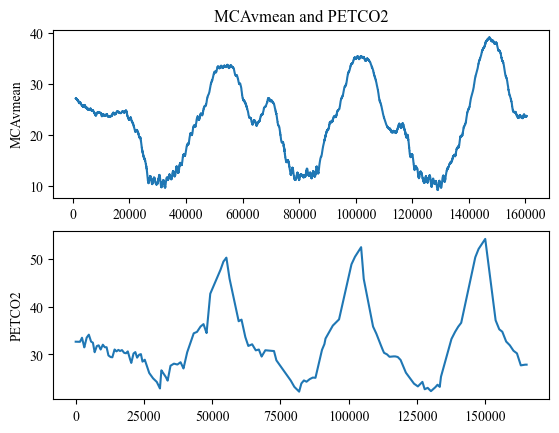

In [77]:
# plot mca and petco2 data
plt.figure()
plt.subplot(2,1,1)
plt.plot(mca.iloc[:,1])
plt.ylabel('MCAvmean')
plt.title('MCAvmean and PETCO2')
plt.subplot(2,1,2)
plt.plot(petco2.iloc[:,1])
plt.ylabel('PETCO2')
plt.show()

In [78]:
# remove NaN values from the data and reset the indices
#print the shape of the mca and petco2 data before removing nans
print('---BEFORE REMOVING NANS---')
print('MCAvmean shape:', mca.shape)
print('PETCO2 shape:', petco2.shape)
print ('nans in mca:', mca.isnull().sum())
print ('nans in petco2:', petco2.isnull().sum())

mca, petco2 = cvr_func.remove_nans(mca, petco2)

print('---AFTER REMOVING NANS---')
print('MCAvmean shape:', mca.shape)
print('PETCO2 shape:', petco2.shape)
print('nans in mca:', mca.isnull().sum())
print('nans in petco2:', petco2.isnull().sum())

---BEFORE REMOVING NANS---
MCAvmean shape: (165250, 2)
PETCO2 shape: (165250, 2)
nans in mca: Unnamed: 0            0
MCAvmean (cm/s)    5797
dtype: int64
nans in petco2: Unnamed: 0       0
PETCO2 (mmHg)    0
dtype: int64
Removing 5797 nan values from both datasets
---AFTER REMOVING NANS---
MCAvmean shape: (159453, 2)
PETCO2 shape: (159453, 2)
nans in mca: Unnamed: 0         0
MCAvmean (cm/s)    0
dtype: int64
nans in petco2: Unnamed: 0       0
PETCO2 (mmHg)    0
dtype: int64


In [79]:
# Calculate the baseline values for mca and petco2
mca_base = cvr_func.get_baseline_values(mca, 17, 8)
petco2_base = cvr_func.get_baseline_values(petco2, 17, 8)

# mca_base = mca.iloc[0:5,1].mean()
# petco2_base = petco2.iloc[0:5,1].mean()
print('---BASELINE VALUES---')
print('MCAvmean baseline value (cm/s):', mca_base)
print('PETCO2 baseline value (mmHg)', petco2_base)

Selecting first 8 values for baseline calculation
Selecting first 8 values for baseline calculation
---BASELINE VALUES---
MCAvmean baseline value (cm/s): 27.16375860991341
PETCO2 baseline value (mmHg) 32.67013798494179


In [80]:
# ### ONLY FOR DATA WITH 4 RAMPS - TO ANALYZE THE FIRST 3 RAMPS ###
# # remove the last quarter of the data
# mca = mca.iloc[0:int(4*len(mca)/5)]
# petco2 = petco2.iloc[0:int(4*len(petco2)/5)]

# # print the shape of the data
# print(mca.shape)
# print(petco2.shape)

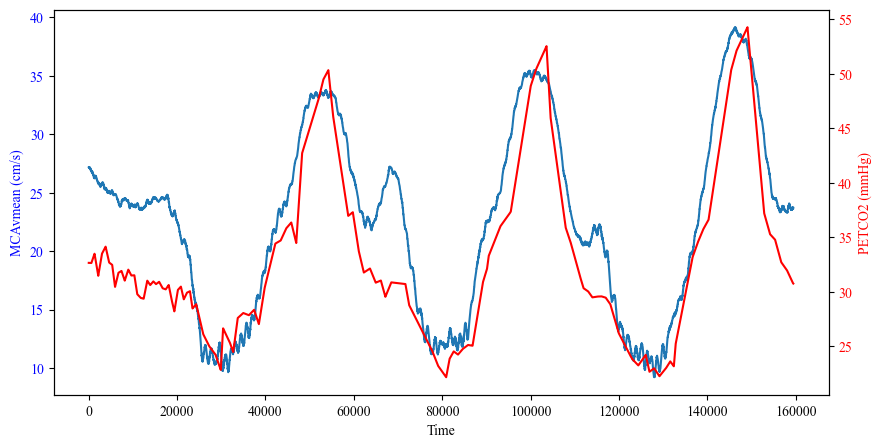

In [81]:
# Plot the first column of mca relative to its index
# Define figure 
fig = plt.figure(figsize=(10,5))
plt.plot(mca.iloc[:,1])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(petco2.iloc[:,1],'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

In [82]:
# save a copy of the figure in the save directory as the data
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_summary_peaks.png'
    fig.savefig(save_dir + '/' + save_name)

(1594, 2)


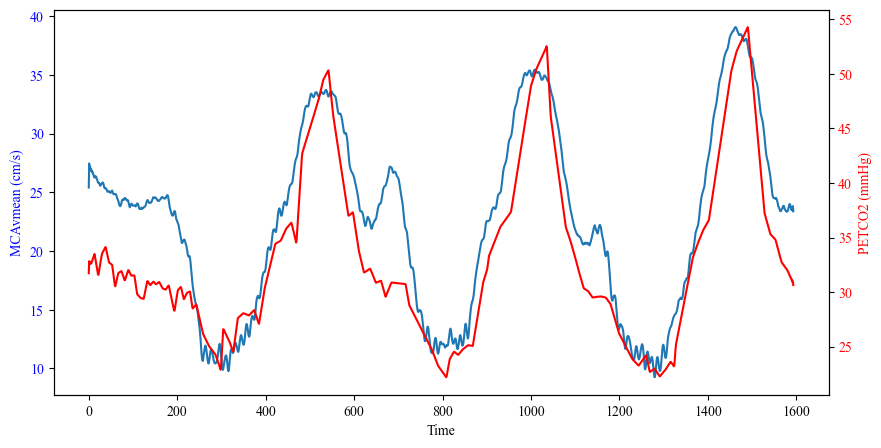

In [83]:
### RESAMPLE ###
# resample the data to 50 times less than the original data
mca_resampled = resample(mca.iloc[:,1], int(len(mca)/100))
petco2_resampled = resample(petco2.iloc[:,1], int(len(petco2)/100))

# redefine as pandas dataframes
mca_resampled = pd.DataFrame(mca_resampled)
petco2_resampled = pd.DataFrame(petco2_resampled)
# reindex the resampled data
mca_resampled = mca_resampled.reset_index(drop=True)
petco2_resampled = petco2_resampled.reset_index(drop=True)


#duplicate the 0th axis to create a new column
mca_resampled.insert(0, 'index', range(0, 0 + len(mca_resampled)))
petco2_resampled.insert(0, 'index', range(0, 0 + len(petco2_resampled)))
print(mca_resampled.shape)


# Plot the first column of mca relative to its index
# Define figure 
fig = plt.figure(figsize=(10,5))
plt.plot(mca_resampled.iloc[:,1])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(petco2_resampled.iloc[:,1],'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

In [84]:
mca = mca_resampled 
petco2 = petco2_resampled

print('---RESAMPLED DATA---')
print('MCAvmean shape:', mca.shape)
print('PETCO2 shape:', petco2.shape)

print(mca)

---RESAMPLED DATA---
MCAvmean shape: (1594, 2)
PETCO2 shape: (1594, 2)
      index          0
0         0  25.412753
1         1  27.464429
2         2  26.954538
3         3  27.194262
4         4  26.926082
...     ...        ...
1589   1589  23.489685
1590   1590  23.648446
1591   1591  23.456820
1592   1592  23.827313
1593   1593  23.390547

[1594 rows x 2 columns]


---SMOOTHED DATA---
MCAvmean shape: (1594, 2)
PETCO2 shape: (1594, 2)
       index          0
0        NaN        NaN
1        NaN        NaN
2        NaN        NaN
3        NaN        NaN
4        NaN        NaN
...      ...        ...
1589  1564.5  24.104017
1590  1565.5  24.044298
1591  1566.5  23.985657
1592  1567.5  23.941352
1593  1568.5  23.896280

[1594 rows x 2 columns]


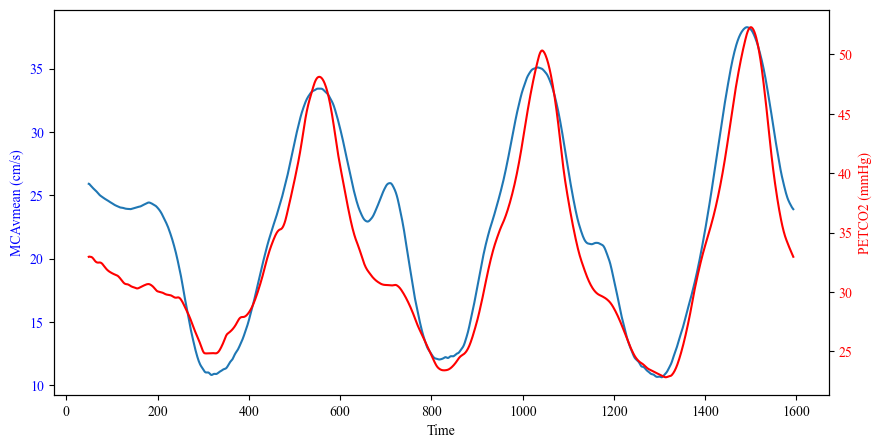

In [85]:
# Smooth the data using a rolling average

# Define the window size for the rolling average
window_size = 50

# Smooth the data within the window
mca_smooth = mca.rolling(window=window_size,center=False).mean()
petco2_smooth = petco2.rolling(window=window_size,center=False).mean()


print('---SMOOTHED DATA---')
print('MCAvmean shape:', mca_smooth.shape)
print('PETCO2 shape:', petco2_smooth.shape)

print(mca_smooth)

# reset the indices
mca_smooth = mca_smooth.reset_index(drop=True)
petco2_smooth = petco2_smooth.reset_index(drop=True)

# Plot the smoothed data
fig = plt.figure(figsize=(10,5))
plt.plot(mca_smooth.iloc[:,1])
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(petco2_smooth.iloc[:,1],'r')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')


In [86]:
mca = mca_smooth 
petco2 = petco2_smooth

In [87]:
# Calculate a t-statistic for the minimum to maximum petco2 data
# Calculate the mean and standard deviation of the petco2 data
petco2_mean = petco2.iloc[:,0].mean()
petco2_std = petco2.iloc[:,0].std()

# Calculate the t-statistic
t_stat = (petco2.iloc[:,0].max() - petco2_mean) / petco2_std
print('PETCO2 t-statistic: ', t_stat)
print('The t-statistic is a measure of how far the maximum petco2 value is from the mean in units of standard deviation')

PETCO2 t-statistic:  1.730369839429711
The t-statistic is a measure of how far the maximum petco2 value is from the mean in units of standard deviation


In [88]:
# Calculate the t-statistic for the minimum to maximum MCAvmean data
# Calculate the mean and standard deviation of the MCAvmean data
mca_mean = mca.iloc[:,0].mean()
mca_std = mca.iloc[:,0].std()

# Calculate the t-statistic
t_stat = (mca.iloc[:,0].max() - mca_mean) / mca_std
print('MCAvmean t-statistic: ', t_stat)
print('The t-statistic is a measure of how far the maximum MCAvmean value is from the mean in units of standard deviation')

MCAvmean t-statistic:  1.730369839429711
The t-statistic is a measure of how far the maximum MCAvmean value is from the mean in units of standard deviation


In [89]:
# NORMALIZE THE MCA DATA RELATIVE TO THE BASELINE MCAvmean

# normalize the mca data relative to the mean of the 5 lowest values
mca_norm = copy.deepcopy(mca)
# scale the mca data (2nd column) in mca_norm by the mean of the lowest values
mca_norm.iloc[:,1] = mca_norm.iloc[:,1] / mca_base

print(mca.shape)
print(mca_norm.shape)

mca = mca_norm

(1594, 2)
(1594, 2)


In [90]:
# ### APPLY MANUAL TEMPORAL SHIFT ###

# # shift the index of the petco2 data by 3 indexes to the right and fill the first 3 values with nan
# petco2 = petco2.shift(1, fill_value=np.nan)

# # Plot the first column of mca relative to its index
# # Define figure 
# fig = plt.figure(figsize=(10,5))
# plt.plot(mca.iloc[:,0])
# plt.xlabel('Time')
# plt.ylabel('MCAvmean (cm/s)', color='b')
# # color the y-axis blue
# plt.tick_params(axis='y',labelcolor='b')
# # Add another axis to plot petco2
# ax2 = plt.twinx()
# ax2.plot(petco2.iloc[:,0],'r')
# ax2.set_ylabel('PETCO2 (mmHg)',color='r')
# ax2.tick_params(axis='y',labelcolor='r')

In [91]:
mca_raw = copy.deepcopy(mca)
petco2_raw = copy.deepcopy(petco2)

In [93]:
print(mca_raw.shape)
print(type(mca_raw))
print(petco2_raw.shape)
print(type(petco2_raw))

# remove duplicate column in mca
mca = mca_raw.iloc[:,1].to_frame()
print(mca.shape)
print(type(mca))

# remove duplicate column in petco2
petco2 = petco2_raw.iloc[:,1].to_frame()
print(petco2.shape)
print(type(petco2))

(1594, 2)
<class 'pandas.core.frame.DataFrame'>
(1594, 2)
<class 'pandas.core.frame.DataFrame'>
(1594, 1)
<class 'pandas.core.frame.DataFrame'>
(1594, 1)
<class 'pandas.core.frame.DataFrame'>


In [94]:
print(mca)
print(petco2)

             0
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
...        ...
1589  0.887359
1590  0.885161
1591  0.883002
1592  0.881371
1593  0.879712

[1594 rows x 1 columns]
              0
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
...         ...
1589  33.318142
1590  33.230974
1591  33.142789
1592  33.057111
1593  32.965445

[1594 rows x 1 columns]


265
240
312
274
240
314
petco2_max_ind [554, 1043, 1500]
petco2_min_ind [307, 828, 1314]
mca_max_ind [552, 1033, 1491]
mca_min_ind [318, 817, 1305]
i= 0
i= 1
i= 2
type of max_idx: <class 'numpy.ndarray'>
type of mca_max_idx: <class 'list'>
max_idx: [ 552 1033 1491]
min_idx: [ 318  828 1314]
[552, 1033, 1491]
[318, 817, 1305]
[554, 1043, 1500]
[554, 1043, 1500]
[ 552 1033 1491]
[ 318  828 1314]
mca_ramp_up shape: (616, 1)
petco2_ramp_up shape: (616, 1)
mca shape: (1594, 1)
mca ramp up shape: (616, 1)
petco2 shape: (1594, 1)
petco2 ramp up shape: (616, 1)


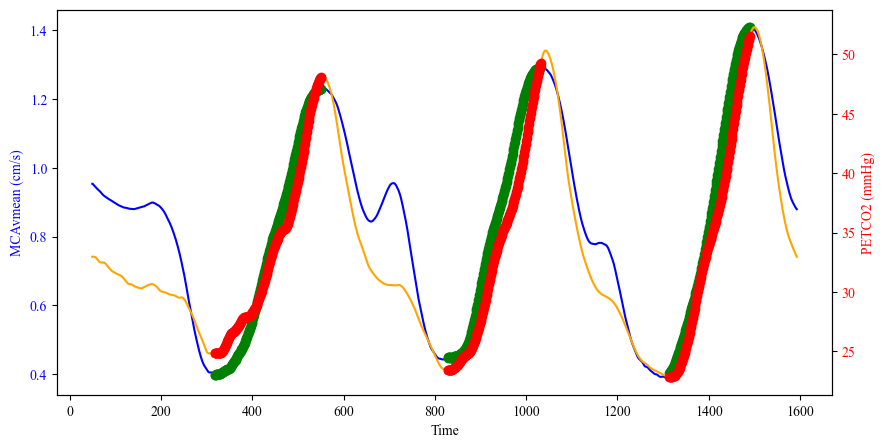

In [ ]:
### separate ramp_down and ramp_up data and plot###
mca_max_idx, mca_min_idx = cvr_func.ramp_identifier_adv(mca, peak_min_distance=peak_min_distance, peak_prominence=peak_prominence, start_search=start_search)
petco2_max_idx, petco2_min_idx = cvr_func.ramp_identifier_adv(petco2, peak_min_distance=peak_min_distance, peak_prominence=peak_prominence, start_search=start_search)
print('petco2_max_ind',petco2_max_idx)
print('petco2_min_ind',petco2_min_idx)
print('mca_max_ind',mca_max_idx)
print('mca_min_ind',mca_min_idx)

# build array max_idx and min_idx to be used in the ramp_segmentor function
# define max_idx as the smallest number first column of mca_max_idx compared to petco2_max_idx
# initialize max_idx as zeros the same size as mca_max_idx
max_idx = np.zeros(np.shape(mca_max_idx))
min_idx = np.zeros(np.shape(mca_min_idx))

for i in range(0, len(mca_max_idx)):
    print('i=', i)
    if mca_max_idx[i] < petco2_max_idx[i]:
        max_idx[i] = mca_max_idx[i]
    else:
        max_idx[i] = petco2_max_idx[i]
        print('petco2 max ind is smaller than mca max ind = ', max_idx)

    if mca_min_idx[i] > petco2_min_idx[i]:
        min_idx[i] = mca_min_idx[i]
    else:
        min_idx[i] = petco2_min_idx[i]

print('type of max_idx:', type(max_idx))
print('type of mca_max_idx:', type(mca_max_idx))

# change max_ind and min_ind to list of integers
max_idx = max_idx.astype(int)
min_idx = min_idx.astype(int)

print('max_idx:', max_idx)
print('min_idx:', min_idx)

mca_ramp_up_relmca, petco2_ramp_up_relmca = cvr_func.ramp_up_segmentor(mca, petco2, mca_max_idx, mca_min_idx)
mca_ramp_up_relpetco2, petco2_ramp_up_relpetco2 = cvr_func.ramp_up_segmentor(mca, petco2, petco2_max_idx, petco2_max_idx)

mca_ramp_up, petco2_ramp_up = cvr_func.ramp_up_segmentor(mca, petco2, max_idx, min_idx)
print('mca_ramp_up shape:', mca_ramp_up.shape)
print('petco2_ramp_up shape:', petco2_ramp_up.shape)


# plot the ramp up data
# Define figure
fig_ramp_up = plt.figure(figsize=(10,5))
#set the font to times
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(mca.iloc[:,0], 'b')
plt.plot(mca_ramp_up.iloc[:,0], 'g', marker='o', linestyle='None')
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(petco2.iloc[:,0],'orange')
ax2.plot(petco2_ramp_up.iloc[:,0],'r', marker='o', linestyle='None')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')
# set mca_ramp_up and petco2_ramp_up to mca and petco2
print('mca shape:',mca.shape)
print('mca ramp up shape:',mca_ramp_up.shape)
print('petco2 shape:',petco2.shape)
print('petco2 ramp up shape:',petco2_ramp_up.shape)

mca shape: (1594, 1)
mca ramp up shape: (616, 1)
petco2 shape: (1594, 1)
petco2 ramp up shape: (616, 1)


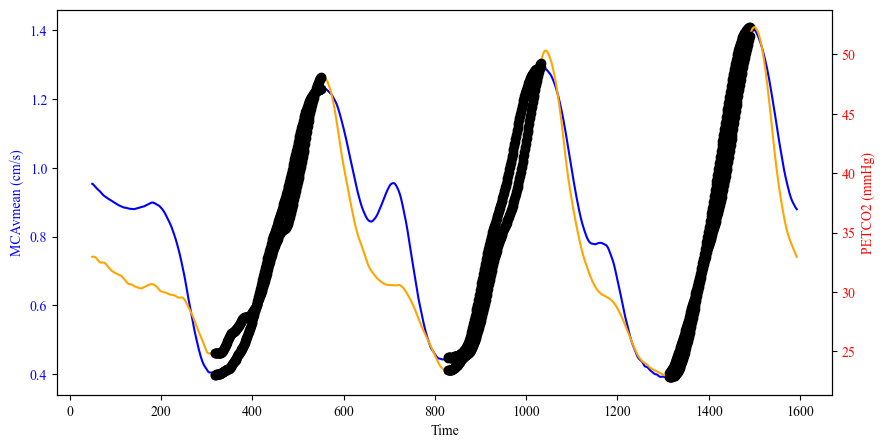

In [ ]:
# plot the ramp up data
# Define figure
fig_ramp_up = plt.figure(figsize=(10,5))
#set the font to times
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(mca.iloc[:,0], 'b')
plt.plot(mca_ramp_up.iloc[:,0], 'k', marker='o', linestyle='None')
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(petco2.iloc[:,0],'orange')
ax2.plot(petco2_ramp_up.iloc[:,0],'k', marker='o', linestyle='None')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')
# set mca_ramp_up and petco2_ramp_up to mca and petco2
print('mca shape:',mca.shape)
print('mca ramp up shape:',mca_ramp_up.shape)
print('petco2 shape:',petco2.shape)
print('petco2 ramp up shape:',petco2_ramp_up.shape)

In [97]:
# save a copy of the figure in the save directory as the data
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_ramp_up.png'
    fig_ramp_up.savefig(save_dir + '/' + save_name)


             0
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
...        ...
1589  0.887359
1590  0.885161
1591  0.883002
1592  0.881371
1593  0.879712

[1594 rows x 1 columns]


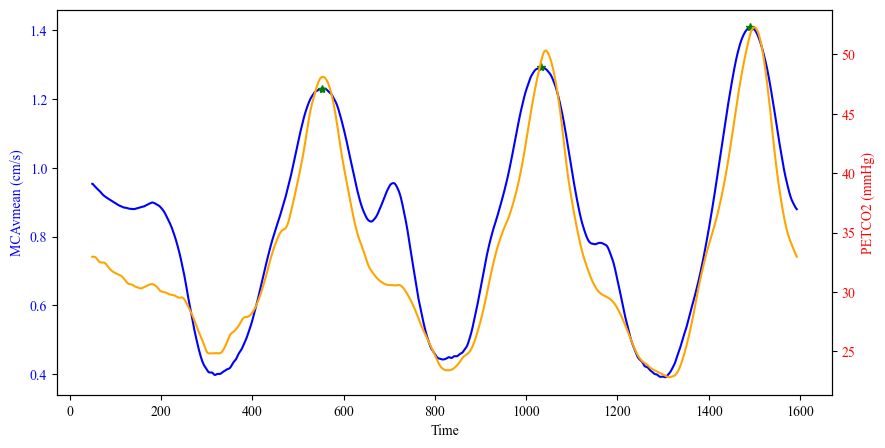

In [ ]:
# mca_max_idx = find_peaks(mca.iloc[:,1], height=1.1, distance=19)[0]
# petco2_max_idx = find_peaks(petco2.iloc[:,1], height=1.1, distance=19)[0]

# plot mca.iloc[:,0] and mca_max_idx on top of it on the first plot and petco2.iloc[:,0] and petco2_max_idx on top of it on the second plot
# Define figure
fig = plt.figure(figsize=(10,5))
#set the font to times
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(mca.iloc[:,0], 'b')
plt.plot(mca_max_idx, mca.iloc[mca_max_idx,0], 'g', marker='*', linestyle='None')
plt.xlabel('Time')
plt.ylabel('MCAvmean (cm/s)', color='b')
# color the y-axis blue
plt.tick_params(axis='y',labelcolor='b')
# Add another axis to plot petco2
ax2 = plt.twinx()
ax2.plot(petco2.iloc[:,0],'orange')
ax2.set_ylabel('PETCO2 (mmHg)',color='r')
ax2.tick_params(axis='y',labelcolor='r')

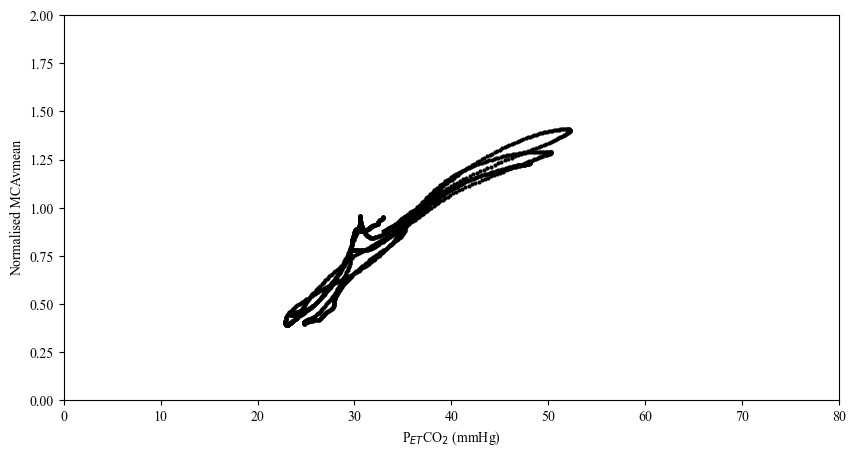

In [99]:
# plot X = PETCO2, Y = MCAvmean Scatter Plot

fig = plt.figure(figsize=(10,5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(petco2.iloc[:,0],mca.iloc[:,0], s=4, c='k')
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('Normalised MCAvmean')
plt.ylim(0,2)
plt.xlim(0,80)
plt.show()

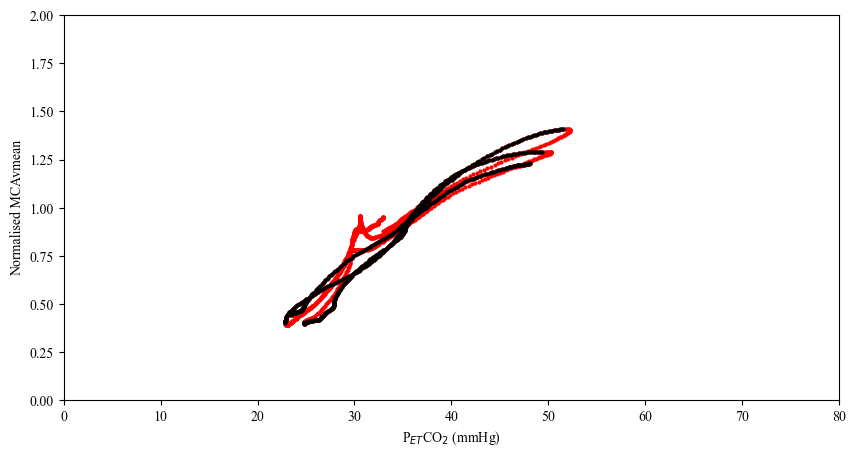

In [100]:
# plot X = PETCO2, Y = MCAvmean Scatter Plot

fig = plt.figure(figsize=(10,5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(petco2.iloc[:,0],mca.iloc[:,0], s=4, c='r')
plt.scatter(petco2_ramp_up.iloc[:,0],mca_ramp_up.iloc[:,0], s=4, c='k')
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('Normalised MCAvmean')
plt.ylim(0,2)
plt.xlim(0,80)
plt.show()

In [101]:
mca = mca_ramp_up
petco2 = petco2_ramp_up

In [102]:
# save a copy of the figure in the save directory as the data
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + 'prefit_scatter.png'
    fig.savefig(save_dir + '/' + save_name)

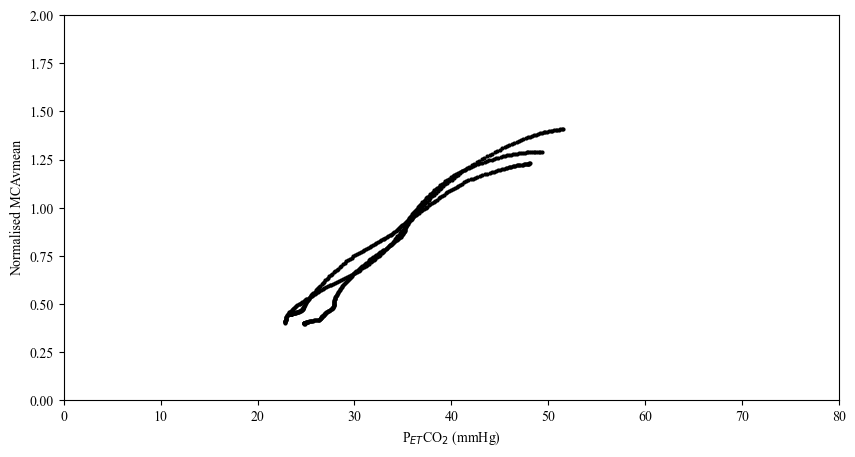

mca shape: (616, 1)
length 616


In [103]:
# plot X = PETCO2, Y = MCAvmean Scatter Plot

fig = plt.figure(figsize=(10,5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(petco2.iloc[:,0],mca.iloc[:,0], s=4, c='k')
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('Normalised MCAvmean')
plt.ylim(0,2)
plt.xlim(0,80)
plt.show()
print('mca shape:',mca.shape)
print('length', len(mca.iloc[:,0]))

y = 0.03844843287849689x + -0.47571525205173903
p = 0.0
r = 0.9810851414421387


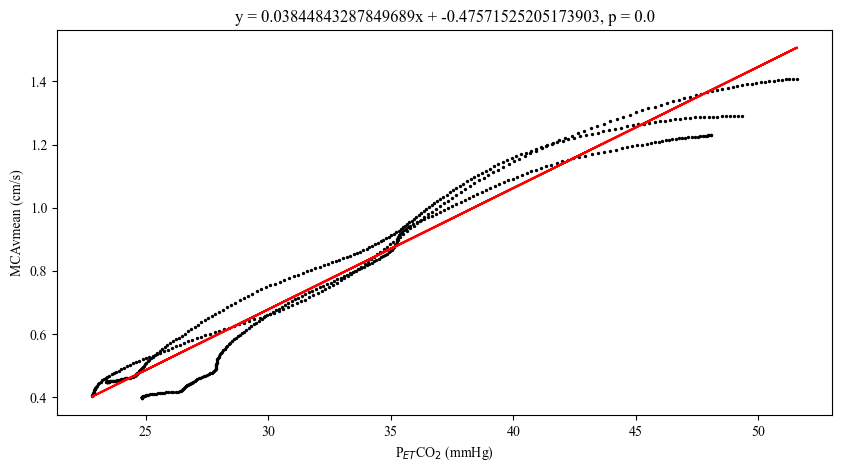

LINEAR CVR = 3.844843287849689 %/mmHg


In [ ]:
# plot X = PETCO2, Y = MCAvmean

# do a linear regression of the data
slope, intercept, r_value, p_value, std_err = stats.linregress(petco2.iloc[:,0],mca.iloc[:,0])
# print the equation of the line
print('y = ' + str(slope) + 'x + ' + str(intercept))
# print the p value
print('p = ' + str(p_value))
# print the r value
print('r = ' + str(r_value))

fig = plt.figure(figsize=(10,5))
plt.scatter(petco2.iloc[:,0],mca.iloc[:,0], s=2, c='k')
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('MCAvmean (cm/s)')
plt.plot(petco2.iloc[:,0], slope*petco2.iloc[:,0] + intercept, 'r')
plt.title('y = ' + str(slope) + 'x + ' + str(intercept) + ', p = ' + str(round(p_value,4)))
plt.show()

print('LINEAR CVR = ' + str(slope*100) + ' %/mmHg')

In [105]:
# save a copy of the figure in the save directory as the data
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + 'linereg.png'
    fig.savefig(save_dir + '/' + save_name)

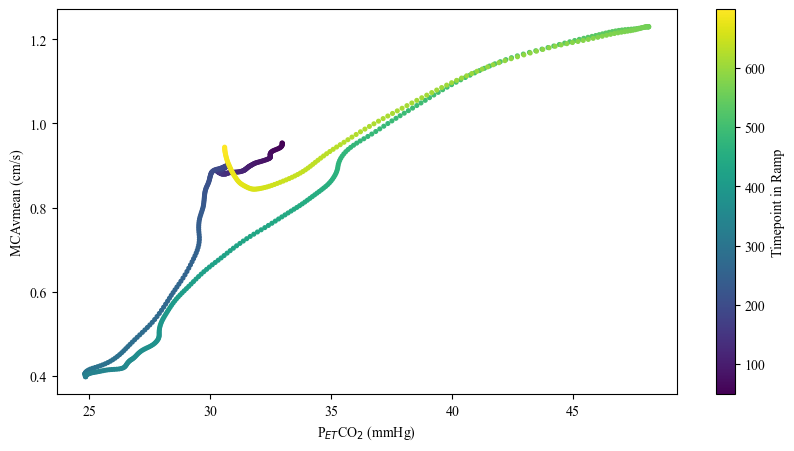

In [ ]:
# plot first ramp X = PETCO2, Y = MCAvmean and color by the index (time)
end_ramp1_index = 700

fig = plt.figure(figsize=(10,5))
plt.scatter(petco2_raw.iloc[:end_ramp1_index,1],mca_raw.iloc[:end_ramp1_index,1], s=7, c=range(end_ramp1_index))
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('MCAvmean (cm/s)')
plt.colorbar().set_label('Timepoint in Ramp')

plt.show()

In [107]:
# save a copy of the figure in the save directory as the data
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_1ramp_colorbar.png'
    fig.savefig(save_dir + '/' + save_name)

In [109]:
## MODELS ##
# 4p model
def fit_4pl(x, a, b, c, d):
    y = a + (d / (1 + np.exp(-(x-c)/b)))
    return (y)
# print the equation and parameters
print('----- 4PL MODEL -----')
model_str_4p = 'a + (d / (1 + np.exp((c-x)/b)'
print(model_str_4p)
# where a = min, b = slope, c = inflection point, d = span
# x = petco2.iloc[:end_ramp1_index,0]
# y = mca.iloc[:end_ramp1_index,0]
x = petco2.iloc[:,0]
y = mca.iloc[:,0]
print(y.max())
#initial guess
a0 = 0.3
b0 = 10
c0 = 35
d0 = 2.5 
p0_4p = [a0, b0, c0, d0]
print('Initial guesses for a0, b0, c0, d0:',p0_4p)
#BOUNDS
p0_bounds_4p=([0, 0, 0, 1],[1, 20, 60, 4])
print('Bounds for a, b, c, d:',p0_bounds_4p)

#fit 4pl
p_opt_4p, cov_p_4p = curve_fit(fit_4pl, x, y, p0=p0_4p, bounds=p0_bounds_4p)
#get optimized model
a_opt_4p, b_opt_4p, c_opt_4p, d_opt_4p = p_opt_4p
x_model_4p = np.linspace(0, 80)
y_model_4p = fit_4pl(x_model_4p, a_opt_4p, b_opt_4p, c_opt_4p, d_opt_4p)




# fit a 5 parameter logistic curve to the data
# 5p MODEL
def fit_5pl(x, a, b, c, d, s):
    y = a + ((d) / (1 + np.exp((c-x)/b)))**s
    return (y)
# print the equation and parameters
print('----- 5PL MODEL -----')
model_str_5p = 'y = a + ((d) / (1 + np.exp((c-x)/b)))**s'
print(model_str_5p)
# where a = min, b = slope, c = inflection point, d = span, s = symmetry
# x = petco2.iloc[:end_ramp1_index,0]
# y = mca.iloc[:end_ramp1_index,0]
#initial guess
a0 = 0.3
b0 = 10
c0 = 35
d0 = 2.5 
s0 = 1
p0_5p = [a0, b0, c0, d0, s0]
print('Initial guesses for a0, b0, c0, d0, s0:',p0_5p)
#BOUNDS
p0_bounds_5p=([0.2, 0, 0, 1, 0],[1, 20, 60, 4, 20])
print('Bounds for a, b, c, d, s:',p0_bounds_5p)

#fit 5pl
p_opt_5p, cov_p_5p = curve_fit(fit_5pl, x, y, p0=p0_5p, bounds=p0_bounds_5p)
#get optimized model
a_opt_5p, b_opt_5p, c_opt_5p, d_opt_5p, s_opt_5p = p_opt_5p
x_model_5p = np.linspace(0, 80)
y_model_5p = fit_5pl(x_model_5p, a_opt_5p, b_opt_5p, c_opt_5p, d_opt_5p, s_opt_5p)

----- 4PL MODEL -----
a + (d / (1 + np.exp((c-x)/b)
1.408371184434411
Initial guesses for a0, b0, c0, d0: [0.3, 10, 35, 2.5]
Bounds for a, b, c, d: ([0, 0, 0, 1], [1, 20, 60, 4])
----- 5PL MODEL -----
y = a + ((d) / (1 + np.exp((c-x)/b)))**s
Initial guesses for a0, b0, c0, d0, s0: [0.3, 10, 35, 2.5, 1]
Bounds for a, b, c, d, s: ([0.2, 0, 0, 1, 0], [1, 20, 60, 4, 20])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


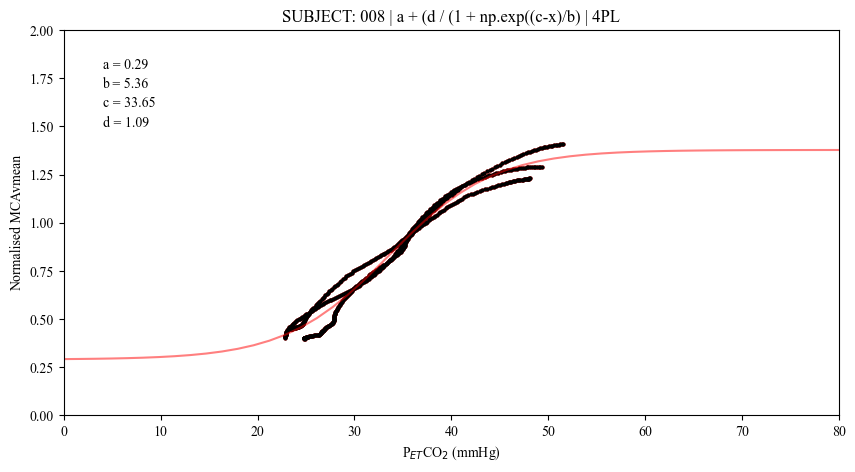

In [110]:
# plot X = PETCO2, Y = MCAvmean Scatter Plot

fig_4p = plt.figure(figsize=(10,5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(petco2.iloc[:,0],mca.iloc[:,0], s=4, c='r')
plt.scatter(petco2_ramp_up.iloc[:,0],mca_ramp_up.iloc[:,0], s=4, c='k')
sns.lineplot(x=x_model_4p, y=y_model_4p, color='r', alpha=0.5)
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('Normalised MCAvmean')
plt.ylim(0,2)
plt.xlim(0,80)

plt.title('SUBJECT: ' + sub_num + ' | '+ model_str_4p +' | 4PL')

# print parameters of the fit on the plot
plt.text(0.05,0.9,'a = ' + str(round(a_opt_4p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.85,'b = ' + str(round(b_opt_4p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.8,'c = ' + str(round(c_opt_4p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.75,'d = ' + str(round(d_opt_4p,2)),transform=plt.gca().transAxes)
# remove the legend
plt.legend().remove()

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


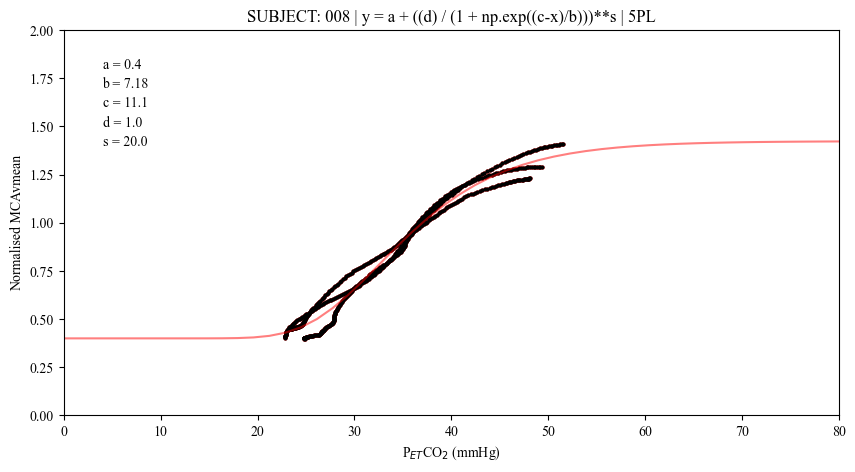

In [111]:
# plot X = PETCO2, Y = MCAvmean Scatter Plot

fig_5p = plt.figure(figsize=(10,5))
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(petco2.iloc[:,0],mca.iloc[:,0], s=4, c='r')
plt.scatter(petco2_ramp_up.iloc[:,0],mca_ramp_up.iloc[:,0], s=4, c='k')
sns.lineplot(x=x_model_5p, y=y_model_5p, color='r', alpha=0.5)
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('Normalised MCAvmean')
plt.ylim(0,2)
plt.xlim(0,80)

plt.title('SUBJECT: ' + sub_num + ' | '+ model_str_5p +' | 5PL')

# print parameters of the fit on the plot
plt.text(0.05,0.9,'a = ' + str(round(a_opt_5p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.85,'b = ' + str(round(b_opt_5p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.8,'c = ' + str(round(c_opt_5p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.75,'d = ' + str(round(d_opt_5p,2)),transform=plt.gca().transAxes)
plt.text(0.05,0.7,'s = ' + str(round(s_opt_5p,2)),transform=plt.gca().transAxes)
# remove the legend
plt.legend().remove()

plt.show()

In [112]:
# if true save the figure
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_4p_model1.png'
    fig.savefig(save_dir + '/' + save_name)

In [113]:
# statistics of the 5p fit

alpha = 0.05 # 95% confidence interval = 100*(1-alpha)

n = len(y)    # number of data points
p = len(p_opt_5p) # number of parameters

dof = max(0, n - p) # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0-alpha/2., dof) 

for i, p, var in zip(range(n), p_opt_5p, np.diag(cov_p_5p)):
    sigma = var**0.5
    print('p{0}: {1} [{2}  {3}]'.format(i, p,
                                  p - sigma*tval,
                                  p + sigma*tval))
    

p0: 0.39926484906477255 [0.339554558524306  0.4589751396052391]
p1: 7.178559137897893 [5.46161590442771  8.895502371368076]
p2: 11.097287800759398 [-66.67479757975642  88.86937318127522]
p3: 1.0012042334634064 [0.9883464346833667  1.014062032243446]
p4: 19.999999999999996 [-180.55560090029252  220.55560090029252]


In [114]:
# calculate the residuals 
residuals_4p = y - fit_4pl(x, *p_opt_4p)
# calculate the sum of the squares of the residuals
ss_res_4p = np.sum(residuals_4p**2)
print('4p sum of the squares of the residuals, ss_res_4p:',ss_res_4p)

4p sum of the squares of the residuals, ss_res_4p: 1.3391191778968248


5p sum of the squares of the residuals, ss_res: 1.3160265785702019
linear sum of the squares of the residuals, ss_res_lin: 2.2410423267690076


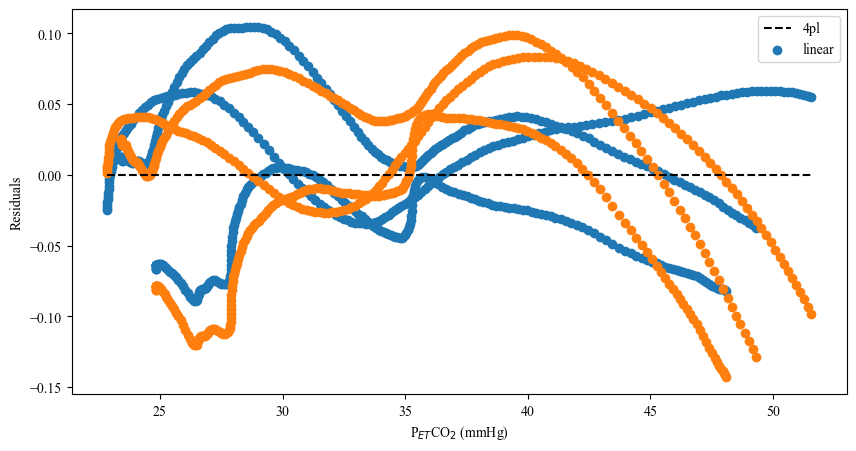

In [115]:
# calculate the residuals 
residuals_5p = y - fit_5pl(x, *p_opt_5p)
# calculate the sum of the squares of the residuals
ss_res_5p = np.sum(residuals_5p**2)
print('5p sum of the squares of the residuals, ss_res:',ss_res_5p)

# calculate the residuals for the linear fit 
residuals_lin = y - (slope*x + intercept)
# calculate the sum of the squares of the residuals
ss_res_lin = np.sum(residuals_lin**2)
print('linear sum of the squares of the residuals, ss_res_lin:',ss_res_lin)


# plot both the residuals in different colours 
fig = plt.figure(figsize=(10,5))
#plot a dotted line at y = 0
plt.plot([np.min(x),np.max(x)],[0,0],'k--')
plt.scatter(x,residuals_5p)
plt.scatter(x,residuals_lin)
plt.xlabel('P$_{ET}$CO$_{2}$ (mmHg)')
plt.ylabel('Residuals')
plt.legend(['4pl','linear'])
plt.show()

In [116]:
# if true save the figure
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_model1residuals.png'
    fig.savefig(save_dir + '/' + save_name)

In [117]:
# get the mean of the lowest 3 values of the petco2 data
petco2_min = petco2.iloc[:,0].nsmallest(3)
# get the mean of petco2_min
petco2_min = petco2_min.mean()
# get the highest 3 values of the petco2 data
petco2_max = petco2.iloc[:,0].nlargest(3)
# get the mean of petco2_max
petco2_max = petco2_max.mean()


petco2_diff = petco2_max - petco2_min
print('PETCO2 max', petco2_max)
print('PETCO2 min', petco2_min)
print('PETCO2 diff', petco2_diff)

# get the mean of the lowest 3 values of the mca data
mca_min = mca.iloc[:,0].nsmallest(3)
# get the mean of mca_min
mca_min = mca_min.mean()
# get the highest 3 values of the mca data
mca_max = mca.iloc[:,0].nlargest(3)
# get the mean of mca_max
mca_max = mca_max.mean()

mca_diff = mca_max - mca_min
print('MCAvmean max', mca_max)
print('MCAvmean min', mca_min)
print('MCAvmean diff', mca_diff)


PETCO2 max 51.41282692992963
PETCO2 min 22.82977918094207
PETCO2 diff 28.58304774898756
MCAvmean max 1.4078179160469781
MCAvmean min 0.3982547455854764
MCAvmean diff 1.0095631704615018


In [118]:
# save and append the a,b,c,d,slope,intercept, max, min, and diff of the petco2 and mca data to a csv file if save_log is true for each subject

csv_log = out_dir + 'ramp_fitting_log_stats_5p.csv'

if save_log == True:
    # get the subject name
    sub_name = str(os.path.basename(out_dir + mca_filepath).split('_')[0])
    # get the petco2 max
    petco2_max = max(petco2.iloc[:,0])
    # get the petco2 min
    petco2_min = min(petco2.iloc[:,0])
    # get the petco2 diff
    petco2_diff = petco2_max - petco2_min
    # get the mca max
    mca_max = max(mca.iloc[:,0])
    # get the mca min
    mca_min = min(mca.iloc[:,0])
    # get the mca diff
    mca_diff = mca_max - mca_min
    # get the slope
    slope = slope
    # get the intercept
    intercept = intercept
    # get the ss_res
    ss_res_5p = ss_res_5p
    # get the ss_res_lin
    ss_res_lin = ss_res_lin
    # get the a_opt
    a_opt_5p = a_opt_5p
    # get the b_opt
    b_opt_5p = b_opt_5p
    # get the c_opt
    c_opt_5p = c_opt_5p
    # get the d_opt
    d_opt_5p = d_opt_5p
    # get the p_value
    p_value = p_value
    # get the r_value
    r_value = r_value
    # get the petco2 diff
    petco2_diff = petco2_diff
    # get the mca diff
    mca_diff = mca_diff

    # create the csv file if it doesn't exist, otherwise append to it
    if not os.path.exists(csv_log):
        with open(csv_log, 'w') as f:
            writer = csv.writer(f)
            writer.writerow(["sub_name","petco2_max","petco2_min","petco2_diff","mca_max","mca_min","mca_diff","slope","intercept","a_opt","b_opt","c_opt","d_opt","petco2_base","mca_base", "ss_res_5p", "ss_res_lin", "p_value", "r_value"])
            writer.writerow([sub_name,petco2_max,petco2_min,petco2_diff,mca_max,mca_min,mca_diff,slope,intercept,a_opt_5p,b_opt_5p,c_opt_5p,d_opt_5p,petco2_base,mca_base, ss_res_5p, ss_res_lin, p_value, r_value])
    else:
        with open(csv_log, 'a') as f:
            writer = csv.writer(f)
            writer.writerow([sub_name,petco2_max,petco2_min,petco2_diff,mca_max,mca_min,mca_diff,slope,intercept,a_opt_5p,b_opt_5p,c_opt_5p,d_opt_5p,petco2_base,mca_base, ss_res_5p, ss_res_lin, p_value, r_value])


# START BAYESIAN FITTING

In [122]:
from BayesicFitting import PolynomialModel
from BayesicFitting import LogisticModel
from BayesicFitting import PowerLawModel
from BayesicFitting import CurveFitter
from BayesicFitting import LevenbergMarquardtFitter
from BayesicFitting import UniformPrior
from BayesicFitting import GaussPrior
from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt

In [ ]:
# define the x and y values for the curve fitting
x = petco2_ramp_up.iloc[:,0]
y = mca_ramp_up.iloc[:,0]

# ensure they are the same length
print(x.shape)
print(y.shape)

(616,)
(616,)


In [ ]:
# define the 4p logistic model
model1 = PolynomialModel(0) + LogisticModel()
# # set limits for the parameters in model 1
# lolim = [0, 0.8, 0, 0]
# uplim = [0.5, 3, 100, 100]
# model1.setLimits( lolim, uplim )

# set priors for the parameters in the model
# model.setPrior( parameter_number , prior=GaussPrior(center=mean, scale=std, limits=[min, max]))
# note that the limits of the priors are set to [-8,+8]*std

# minimum center at ~30% +/- 15% blood flow (limits at 0.15*8 = +/- 1.2)
model1.setPrior( 0, prior=GaussPrior(center=0.3, scale=0.15, limits=[0,1]))
# span center at ~250% +/- 80% blood flow (limits at 0.5*8 = +/- 4)
model1.setPrior( 1, prior=GaussPrior(center=2.5, scale=0.5, limits=[1,4]))
model1.setPrior( 2, prior=GaussPrior(center=35, scale=4, limits=[0,60]))
model1.setPrior( 3, prior=GaussPrior(center=10, scale=5, limits=[0,20]))

print( model1 )

Polynomial: f( x:p ) = p_0 +
Logistic: f( x:p ) = p_1 / ( 1 + exp( ( p_2 - x ) / p_3 ) )


Fit all parameters of
  Polynomial: f( x:p ) = p_0 +
  Logistic: f( x:p ) = p_1 / ( 1 + exp( ( p_2 - x ) / p_3 ) )
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine
>

>

/Users/ghayes/miniconda3/envs/sigcvr/lib/python3.9/site-packages/BayesicFitting/source/LogisticModel.py:113: RuntimeWarning: overflow encountered in exp
  res = params[0] / ( 1 + numpy.exp( x ) )


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Iteration     logZ        H       LowL     npar
    3326       983.     23.3   1.01e+03      5  
Parameters  [    0.224    1.188   33.298    6.065    0.046]
Engines              success     reject     failed      calls
GalileanEngine         10363       7436      12871       3326
ChordEngine            23461      83419          0       3326
Calls to LogL         144986   to dLogL       7436
Samples        3426
Evidence       427.102 +-      0.209


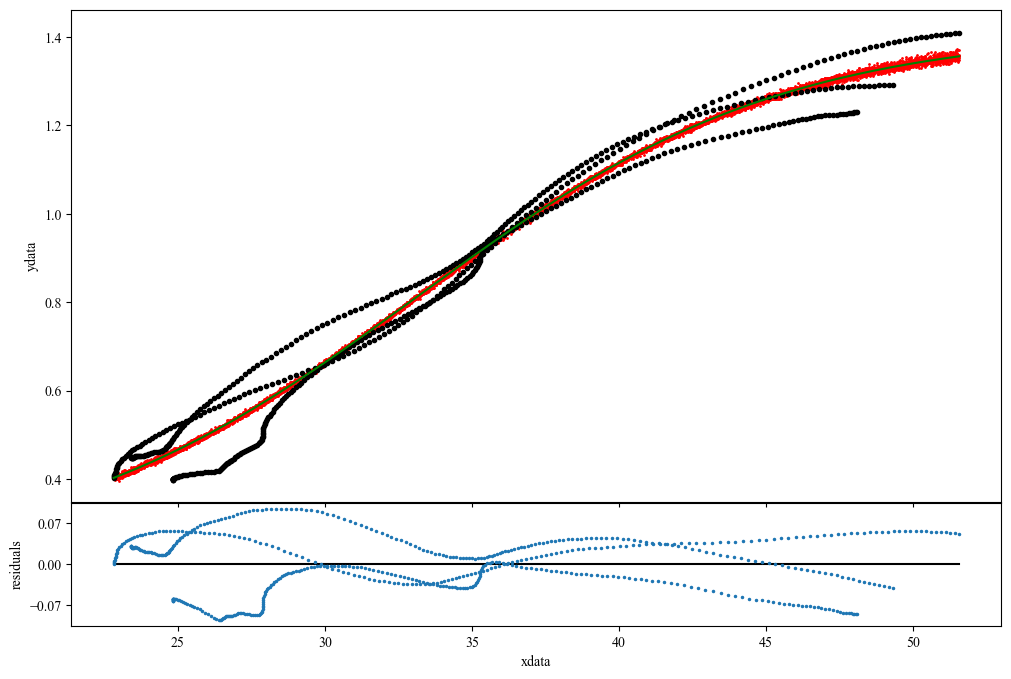

GaussPrior at (0.30 0.15) with limits between 0.00 and 1.00
GaussPrior at (2.50 0.50) with limits between 1.00 and 4.00
GaussPrior at (35.00 4.00) with limits between 0.00 and 60.00
GaussPrior at (10.00 5.00) with limits between 0.00 and 20.00


In [ ]:
# define NestedSampler
ns = NestedSampler( x, model1, y, weights=None, seed=1301 )
# set limits on the noise scale of the distribution
ns.distribution.setLimits( [0.01,100] )
# run NestedSampler
evi = ns.sample( plot=True )

print(model1.getPrior(0))
print(model1.getPrior(1))
print(model1.getPrior(2))
print(model1.getPrior(3))

In [126]:
sl = ns.samples
par = sl.parameters
std = sl.stdevs
print( "             p1       p2       p3       p4    ")
print( "params  ", fmt( par, max=None ) )
print( "stdevs  ", fmt( std, max=None ) )
pal = par.copy()
stl = std.copy()
print( "params  ", fmt( pal, max=None ) )
print( "stdevs  ", fmt( stl, max=None ) )
print( "scale   ", fmt( sl.scale ), " +-", fmt( sl.stdevScale ) )
print( "evidence", fmt( evi ) )

             p1       p2       p3       p4    
params   [    0.210    1.205   33.143    6.215]
stdevs   [    0.005    0.010    0.146    0.091]
params   [    0.210    1.205   33.143    6.215]
stdevs   [    0.005    0.010    0.146    0.091]
scale        0.047  +-     0.001
evidence   427.102


--- before incorporating offset ---
Logistic: f( x:p ) = p_0 / ( 1 + exp( ( p_1 - x ) / p_2 ) ) |
PowerLaw: f( x:p ) = (1.0) * ( x - (0.0) ^p_3
Number of parameters in model5p: 4
--- after incorporating offset ---
Polynomial: f( x:p ) = p_0 +
{ Logistic: f( x:p ) = p_1 / ( 1 + exp( ( p_2 - x ) / p_3 ) ) |
  PowerLaw: f( x:p ) = (1.0) * ( x - (0.0) ^p_4 }
Number of parameters in model5p: 5
Fit all parameters of
  Polynomial: f( x:p ) = p_0 +
  { Logistic: f( x:p ) = p_1 / ( 1 + exp( ( p_2 - x ) / p_3 ) ) |
    PowerLaw: f( x:p ) = (1.0) * ( x - (0.0) ^p_4 }
Using a Gauss error distribution with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine
>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Iteration     logZ        H       LowL     npar
    3588       984.     23.8   1.01e+03      6  
Parameters  [    0.239    1.173   34.315    5.517    0.865    0.047]
Engines              success     reject     failed      calls
GalileanEngine         12145       8539      14149       3588
ChordEngine            25129      98888          0       3588
Calls to LogL         167389   to dLogL       8539
Samples        3688
Evidence       427.193 +-      0.212


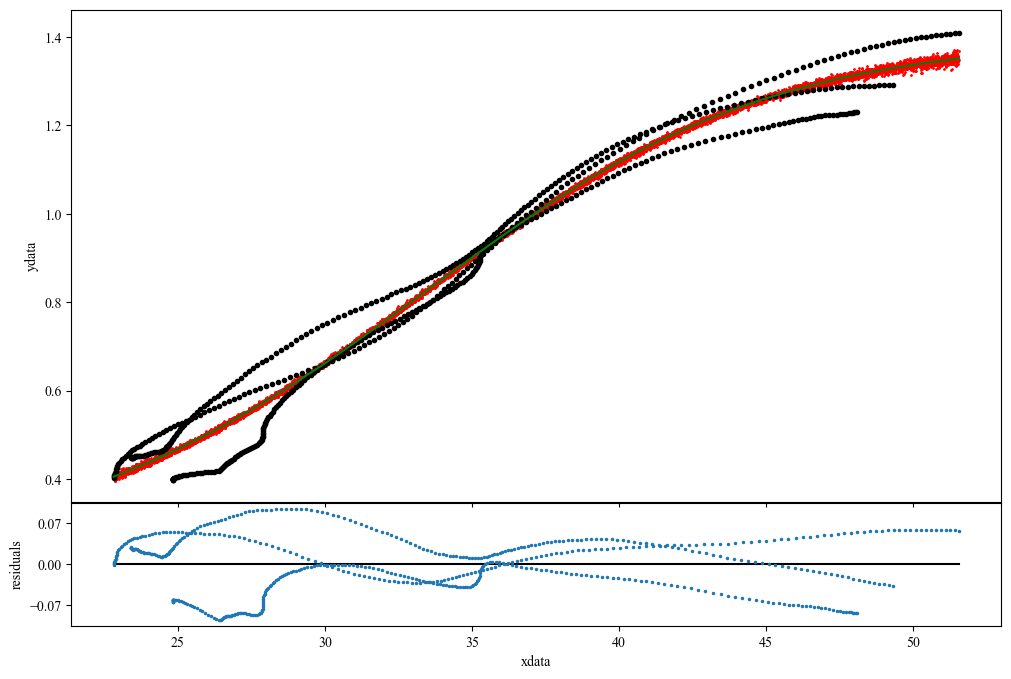

GaussPrior at (0.30 0.15) with limits between 0.00 and 1.00
GaussPrior at (2.50 0.50) with limits between 1.00 and 4.00
GaussPrior at (35.00 4.00) with limits between 0.00 and 60.00
GaussPrior at (10.00 5.00) with limits between 0.00 and 20.00
GaussPrior at (1.00 0.50) with limits between 0.10 and 10.00


In [ ]:
m1 = PowerLawModel( fixed={0:1.0, 1:0.0} )
m2 = LogisticModel()
m3 = m2 | m1
model5p = m3
print('--- before incorporating offset ---')
print( model5p )
print('Number of parameters in model5p:', model5p.getNumberOfParameters())

# span center at ~250% +/- 80% blood flow (limits at 0.5*8 = +/- 4)
model5p.setPrior( 0, prior=GaussPrior(center=2.5, scale=0.5, limits=[1,4]))
model5p.setPrior( 1, prior=GaussPrior(center=35,scale=4, limits=[0,60]))
model5p.setPrior( 2, prior=GaussPrior(center=10, scale=5, limits=[0,20]))
model5p.setPrior( 3, prior=GaussPrior(center=1, scale=0.5, limits=[0.1,10]))

# Add an offset to the logistic model
polynomial = PolynomialModel(0)
polynomial.setLimits( [0],[1] )
#polynomial.setPrior( 0, prior=GaussPrior(center=0.25, limits=[0.15,0.5]))
polynomial.setPrior( 0, prior=GaussPrior(center=0.3, scale=0.15, limits=[0,1]))

print('--- after incorporating offset ---')
model5p = polynomial + model5p
print( model5p )
print('Number of parameters in model5p:', model5p.getNumberOfParameters())

# define NestedSampler
ns5p = NestedSampler( x, model5p, y, weights=None, seed=1127 )
# set limits on the noise scale of the distribution
ns5p.distribution.setLimits( [0.01,100] )
# run NestedSampler
evi5p = ns5p.sample( plot=True )

print(model5p.getPrior(0))
print(model5p.getPrior(1))
print(model5p.getPrior(2))
print(model5p.getPrior(3))
print(model5p.getPrior(4))

In [128]:
sl5p = ns5p.samples
par5p = sl5p.parameters
std5p = sl5p.stdevs
print( "                p0       p1       p2       p3       p4    ")
print( "params  ", fmt( par5p, max=None ) )
print( "stdevs  ", fmt( std5p, max=None ) )
pal5p = par5p.copy()
stl5p = std5p.copy()
print( "params  ", fmt( pal5p, max=None ) )
print( "stdevs  ", fmt( stl5p, max=None ) )
print( "scale   ", fmt( sl5p.scale ), " +-", fmt( sl5p.stdevScale ) )
print( "evidence", fmt( evi5p ) )

                p0       p1       p2       p3       p4    
params   [    0.190    1.293   34.987    5.647    0.776]
stdevs   [    0.036    0.099    0.996    0.334    0.125]
params   [    0.190    1.293   34.987    5.647    0.776]
stdevs   [    0.036    0.099    0.996    0.334    0.125]
scale        0.047  +-     0.001
evidence   427.193


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


size of PETCO2: (616,)
size of MCAvmean: (616,)


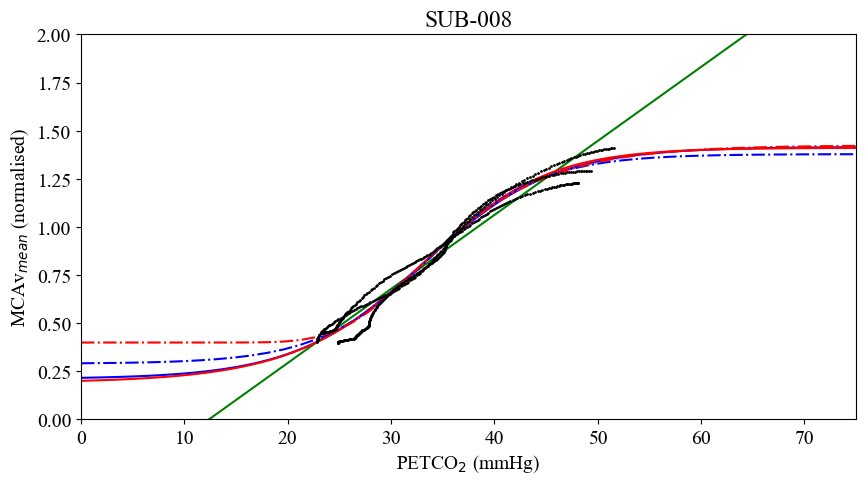

In [129]:
fig_fits = plt.figure( "nestedsamplerfit", figsize=[10,5] )
# increase font size of the axis labels on the plots
plt.rcParams.update({'font.size': 14})

print('size of PETCO2:', x.shape)
print('size of MCAvmean:', y.shape)
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'


xx = np.linspace( 0, 75, 100, dtype=float )

plt.plot(xx, slope*xx + intercept, 'g-')

plt.plot( xx, model1.result( xx, par ), 'b-')
#plt.plot( xx, model1.result( xx, param2 ), 'r-' )
plt.plot( xx, model5p.result( xx, par5p ), 'r-' )

plt.plot( x_model_4p, y_model_4p, 'b-.' )
plt.plot( x_model_5p, y_model_5p, 'r-.' )


plt.plot( x, y, 'k. ', markersize=2 )


# sns.lineplot(x=x_model_4p, y=y_model_4p, color='y', alpha=0.5)
# sns.lineplot(x=x_model_5p, y=y_model_5p, color='b', alpha=0.5)
plt.xlabel( "PETCO$_{2}$ (mmHg)")
plt.ylabel( "MCAv$_{mean}$ (normalised)")
plt.title('SUB-' + sub_num )
# remove legend
plt.legend().remove()
plt.xlim( 0, 75 )
plt.ylim( 0, 2)
plt.show()

In [130]:
# save the figure
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_linefits.png'
    fig_fits.savefig(save_dir + '/' + save_name)


size of PETCO2: (616,)
size of MCAvmean: (616,)


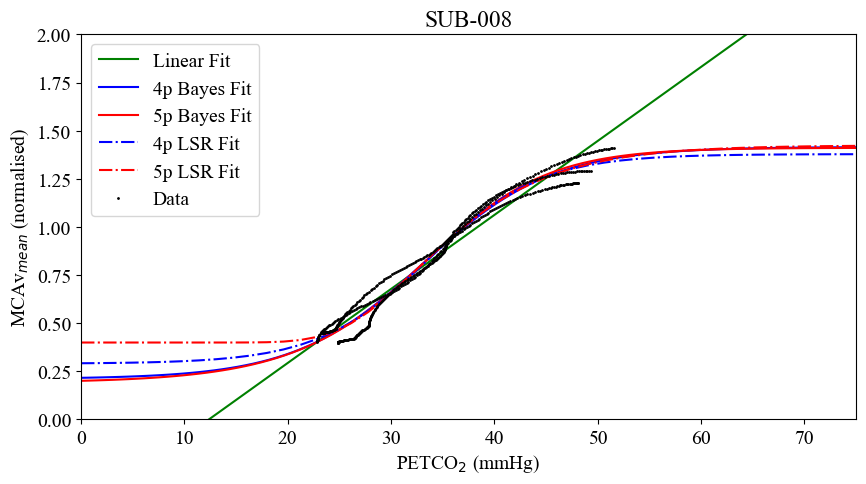

In [131]:
fig_fits = plt.figure( "nestedsamplerfit", figsize=[10,5] )
# increase font size of the axis labels on the plots
plt.rcParams.update({'font.size': 14})

print('size of PETCO2:', x.shape)
print('size of MCAvmean:', y.shape)
# set font to times new roman
plt.rcParams['font.family'] = 'Times New Roman'


xx = np.linspace( 0, 75, 100, dtype=float )

plt.plot(xx, slope*xx + intercept, 'g-')

plt.plot( xx, model1.result( xx, par ), 'b-')
#plt.plot( xx, model1.result( xx, param2 ), 'r-' )
plt.plot( xx, model5p.result( xx, par5p ), 'r-' )

plt.plot( x_model_4p, y_model_4p, 'b-.' )
plt.plot( x_model_5p, y_model_5p, 'r-.' )


plt.plot( x, y, 'k. ', markersize=2 )


# sns.lineplot(x=x_model_4p, y=y_model_4p, color='y', alpha=0.5)
# sns.lineplot(x=x_model_5p, y=y_model_5p, color='b', alpha=0.5)
plt.xlabel( "PETCO$_{2}$ (mmHg)")
plt.ylabel( "MCAv$_{mean}$ (normalised)")
plt.title('SUB-' + sub_num )
#plt.legend( ["Data", "4p Nested Sampler Fit", "4p Bounded LM Fit", "4p Prior LM Fit", "Asymmetric LM Fit", "Asymmetric NS Fit"] )
plt.legend( ["Linear Fit", "4p Bayes Fit", "5p Bayes Fit", "4p LSR Fit", "5p LSR Fit", "Data"])
plt.xlim( 0, 75 )
plt.ylim( 0, 2)
plt.show()


In [132]:
# save the figure
if save_fig == True:
    save_dir = os.path.dirname(out_dir + mca_filepath)
    save_name = os.path.basename(out_dir + mca_filepath).split('.')[0] + '_linefits_legend.png'
    fig_fits.savefig(save_dir + '/' + save_name)

In [133]:
# save a log file with the values of the parameters for the LSR and NS fits (4p and 5p)

if save_log == True:
    sub_name = str(os.path.basename(out_dir + mca_filepath).split('_')[0])
    print('Subject name:', sub_name)

    csv_para_log_name_NS = out_dir + 'parameter_log_bayes.csv'
    para_log_NS = pd.DataFrame({'sub':[sub_name],'a_opt_4p_NS':[par[0]], 'b_opt_4p_NS':[par[3]], 'c_opt_4p_NS':[par[2]], 'd_opt_4p_NS':[par[1]], 'a_opt_5p_NS':[par5p[0]], 'b_opt_5p_NS':[par5p[3]], 'c_opt_5p_NS':[par5p[2]], 'd_opt_5p_NS':[par5p[1]], 's_opt_5p_NS':[par5p[4]]})
    # if the file does not exist, create it
    if not os.path.exists(csv_para_log_name_NS):
        para_log_NS.to_csv(csv_para_log_name_NS, index=False)
    # if the file exists, append to it
    else:
        para_log_NS.to_csv(csv_para_log_name_NS, mode='a', header=False, index=False)
    print('Bayes parameter log saved to:', csv_para_log_name_NS)


    csv_para_log_name_LSR = out_dir + 'parameter_log_LSR.csv'
    para_log_LSR = pd.DataFrame({'sub':[sub_name],'a_opt_4p':[a_opt_4p], 'b_opt_4p':[b_opt_4p], 'c_opt_4p':[c_opt_4p], 'd_opt_4p':[d_opt_4p], 'a_opt_5p':[a_opt_5p], 'b_opt_5p':[b_opt_5p], 'c_opt_5p':[c_opt_5p], 'd_opt_5p':[d_opt_5p], 's_opt_5p':[s_opt_5p]})
    # if the file does not exist, create it
    if not os.path.exists(csv_para_log_name_LSR):
        para_log_LSR.to_csv(csv_para_log_name_LSR, index=False)
    # if the file exists, append to it
    else:
        para_log_LSR.to_csv(csv_para_log_name_LSR, mode='a', header=False, index=False)
    print('LSR parameter log saved to:', csv_para_log_name_LSR)


Subject name: sub-008
Bayes parameter log saved to: /Users/ghayes/Desktop/Ramp_PWL/sample_data/parameter_log_bayes.csv
LSR parameter log saved to: /Users/ghayes/Desktop/Ramp_PWL/sample_data/parameter_log_LSR.csv


In [ ]:
# calcualte the sum of squares of the residuals for the LSR and NS fits (4p and 5p)

#print the subject number
print('Subject number:', sub_num)

print('Sum of squares of residuals, smaller is better')

# linear LSR
print('Sum of squares of residuals for linear LSR:', ss_res_lin)

# 4p LSR
print('Sum of squares of residuals for 4p LSR:', ss_res_4p)

# 5p LSR
print('Sum of squares of residuals for 5p LSR:', ss_res_5p)

# 4p NS
ss_res_4p_NS = np.sum((y - model1.result(x, par))**2)
print('Sum of squares of residuals for 4p NS:', ss_res_4p_NS)

# 5p NS
ss_res_5p_NS = np.sum((y - model5p.result(x, par5p))**2)
print('Sum of squares of residuals for 5p NS:', ss_res_5p_NS)

Subject number: 008
Sum of squares of residuals, smaller is better
Sum of squares of residuals for linear LSR: 2.2410423267690076
Sum of squares of residuals for 4p LSR: 1.3391191778968248
Sum of squares of residuals for 5p LSR: 1.3160265785702019
Sum of squares of residuals for 4p NS: 1.3638168930633658
Sum of squares of residuals for 5p NS: 1.382421158278612


In [135]:
# save a log file with the sum of squares of residuals for the LSR and NS fits (4p and 5p)

if save_log == True:
    sub_name = str(os.path.basename(out_dir + mca_filepath).split('_')[0])
    print('Subject name:', sub_name)

    csv_ss_res_log_name = out_dir + 'ss_res_log.csv'
    ss_res_log = pd.DataFrame({'sub':[sub_name],'ss_res_lin':[ss_res_lin], 'ss_res_4p':[ss_res_4p], 'ss_res_5p':[ss_res_5p], 'ss_res_4p_bayes':[ss_res_4p_NS], 'ss_res_5p_bayes':[ss_res_5p_NS]})
    # if the file does not exist, create it
    if not os.path.exists(csv_ss_res_log_name):
        ss_res_log.to_csv(csv_ss_res_log_name, index=False)
    # if the file exists, append to it
    else:
        ss_res_log.to_csv(csv_ss_res_log_name, mode='a', header=False, index=False)
    print('Sum of squares of residuals log saved to:', csv_ss_res_log_name)

Subject name: sub-008
Sum of squares of residuals log saved to: /Users/ghayes/Desktop/Ramp_PWL/sample_data/ss_res_log.csv


In [136]:
# Bayesian Information Criterion (BIC) for the LSR and NS fits (4p and 5p)
# and Akaikes Information Criterion (AIC) for the LSR and NS fits (4p and 5p)

# number of data points
n = len(y)

# number of parameters in the model
k_lin = 2
k_4p = 4
k_5p = 5
k_4p_NS = 4
k_5p_NS = 5

# calculate the BIC for the LSR and NS fits (4p and 5p)
def calculate_BIC(n, k, ss_res):
    bic = n * np.log(ss_res/n) + k * np.log(n)
    return bic

# calculate the AIC for the LSR and NS fits (4p and 5p)
def calculate_AIC(n, k, ss_res):
    aic = n * np.log(ss_res/n) + 2 * k
    return aic

# linear LSR
bic_lin = calculate_BIC(n, k_lin, ss_res_lin)
aic_lin = calculate_AIC(n, k_lin, ss_res_lin)

# 4p LSR
bic_4p = calculate_BIC(n, k_4p, ss_res_4p)
aic_4p = calculate_AIC(n, k_4p, ss_res_4p)

# 5p LSR
bic_5p = calculate_BIC(n, k_5p, ss_res_5p)
aic_5p = calculate_AIC(n, k_5p, ss_res_5p)

# 4p NS
bic_4p_NS = calculate_BIC(n, k_4p_NS, ss_res_4p_NS)
aic_4p_NS = calculate_AIC(n, k_4p_NS, ss_res_4p_NS)

# 5p NS
bic_5p_NS = calculate_BIC(n, k_5p_NS, ss_res_5p_NS)
aic_5p_NS = calculate_AIC(n, k_5p_NS, ss_res_5p_NS)

print('Subject number:', sub_num)
print('BIC, smaller is better')
# linear LSR
print('BIC for linear LSR:', bic_lin)
# 4p LSR
print('BIC for 4p LSR:', bic_4p)
# 5p LSR
print('BIC for 5p LSR:', bic_5p)
# 4p NS
print('BIC for 4p NS:', bic_4p_NS)
# 5p NS
print('BIC for 5p NS:', bic_5p_NS)

print('---------------------------------')
print('AIC, smaller is better')
# linear LSR
print('AIC for linear LSR:', aic_lin)
# 4p LSR
print('AIC for 4p LSR:', aic_4p)
# 5p LSR
print('AIC for 5p LSR:', aic_5p)
# 4p NS
print('AIC for 4p NS:', aic_4p_NS)
# 5p NS
print('AIC for 5p NS:', aic_5p_NS)

Subject number: 008
BIC, smaller is better
BIC for linear LSR: -3446.7979290436506
BIC for 4p LSR: -3751.1477078567054
BIC for 5p LSR: -3755.4398047434256
BIC for 4p NS: -3739.8901600852555
BIC for 5p NS: -3725.120657277325
---------------------------------
AIC, smaller is better
AIC for linear LSR: -3455.6444229707176
AIC for 4p LSR: -3768.8406957108396
AIC for 5p LSR: -3777.5560395610933
AIC for 4p NS: -3757.5831479393896
AIC for 5p NS: -3747.2368920949925


In [137]:
# save a log file with the sum of bic and aic for the LSR and NS fits (4p and 5p)

if save_log == True:
    sub_name = str(os.path.basename(out_dir + mca_filepath).split('_')[0])
    print('Subject name:', sub_name)

    csv_bic_log_name = out_dir + 'bic_aic_log.csv'
    bic_log = pd.DataFrame({'sub':[sub_name],'bic_lin':[bic_lin], 'bic_4p':[bic_4p], 'bic_5p':[bic_5p], 'bic_4p_bayes':[bic_4p_NS], 'bic_5p_bayes':[bic_5p_NS], 'aic_lin':[aic_lin], 'aic_4p':[aic_4p], 'aic_5p':[aic_5p], 'aic_4p_bayes':[aic_4p_NS], 'aic_5p_bayes':[aic_5p_NS]})
    # if the file does not exist, create it
    if not os.path.exists(csv_bic_log_name):
        bic_log.to_csv(csv_bic_log_name, index=False)
    # if the file exists, append to it
    else:
        bic_log.to_csv(csv_bic_log_name, mode='a', header=False, index=False)
    print('BIC and AIC stats log saved to:', csv_bic_log_name)

Subject name: sub-008
BIC and AIC stats log saved to: /Users/ghayes/Desktop/Ramp_PWL/sample_data/bic_aic_log.csv
